In [334]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr
from scipy.special import expit
import copy

np.random.seed(333)

# Gibbs sampling with refractory period

In [2]:
images = np.load('images_zca_norm.npy')
PFs = np.load('pfs.npy')

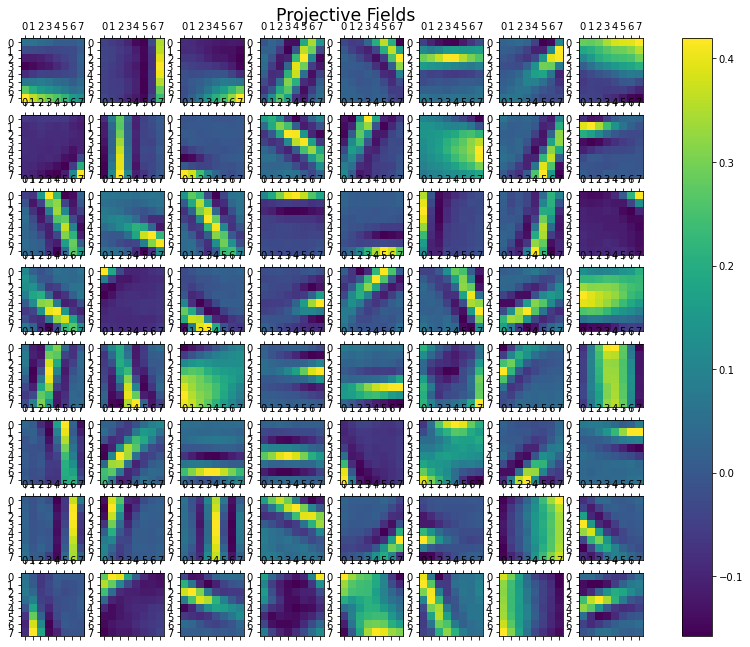

In [155]:
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(14, 11))

for i in range(8):
    for j in range(8):
        order = i*8 +j                             # neuron number
        ax = axes[i][j].matshow(PFs[order])
        
fig.colorbar(ax, ax=axes[:, :], location='right')

fig.suptitle('Projective Fields', x = 0.45, y = 0.92, size = 'xx-large')

#fig.tight_layout(pad=3.0)
plt.show()

In [162]:
z_initial = np.random.binomial(1, 0.1, 64)     # Draw initial z vector from a Gaussian dist.
                                                # Here we used small probability to shorten the burn-in time
                                                # z defines if a neuron is firing or not, being either 1 or 0
Pf = np.transpose(PFs.reshape(64,64))           # Define weight matrix such as
                                                # every column corresponds to PF of the corresponding neuron
W = np.matmul(np.transpose(Pf[:,:]),Pf[:,:])    # Generate weight matrix 
Time = 0.5 #sec
delta_T = 0.001 #sec
N_sampling = int(Time/delta_T)                       # Sampling count = 400
tau = 5 #msec                                    Hard refractory period

In [124]:
def post_synaptic_potential(Image, i, z):
    weight_i = copy.copy(W[i])
    weight_i[i] = 0                                                    # w_ii = 0
    time_course = np.matmul(np.transpose(weight_i),z)                  # how other neurons contribute PSP now
    bias = np.matmul(np.transpose(Pf[:,i]),Image.reshape(64,1))        # regulation of own excitability
    return bias - time_course

In [275]:
def Gibbs_sampling(Image, n_sampling):
    response_matrix = np.zeros([64,n_sampling])  # Initiate sampling matrix
    response_matrix[:,0] = z_initial             # Set z_initial as the first column
    
    ζ = np.zeros([64,n_sampling])                # accompanying matrix showing the refractory period
    ζ[:,0] = z_initial*tau                       # firing neurons get into refractory period
    
    spike_timing = np.zeros([64,n_sampling])     # record spike times
    
    for i in range(1, n_sampling):               # Start from the second column, and iterate through time
        response_matrix[:,i] = response_matrix[:,i-1]
        
###### Discuss whether we should update it syncronously or (in-line)
# they will effect each other in the same sampling if we do it in-line

        for j in range(64):                       
            if ζ[j, i-1] <= 1:                   # Make a draw if refractory period is end
                
                response_matrix[j, i] = 0
                transfer_ij = expit(post_synaptic_potential(Image, j, response_matrix[:,i])\
                                    - np.log(tau)) # expit for sigmoid fct
                ######  x * (x > 0)
                response_matrix[j,i] = np.random.binomial(1, transfer_ij)
                
                if response_matrix[j,i] == 1:   # update refractory period
                    ζ[j, i] = tau                
                    spike_timing[j, i] = i      # record spike time
                else:
                    ζ[j, i] = 0
                
            else:
                ζ[j, i] = ζ[j, i-1] - 1
   
    return response_matrix

In [248]:
expit(post_synaptic_potential(Pf[:,28], 43, z_initial) - np.log(tau))

array([0.13136642])

In [249]:
def posterior_prob_r(Image, n_sampling):
    response = Gibbs_sampling(Image, n_sampling)
    return [np.sum(response[i])/n_sampling for i in range(64)]  # Return firing percentage

In [250]:
post_synaptic_potential(Pf[:,sample_neuron_number], 5, z_initial)

array([-0.54300416])

## Trial with a sample projective field

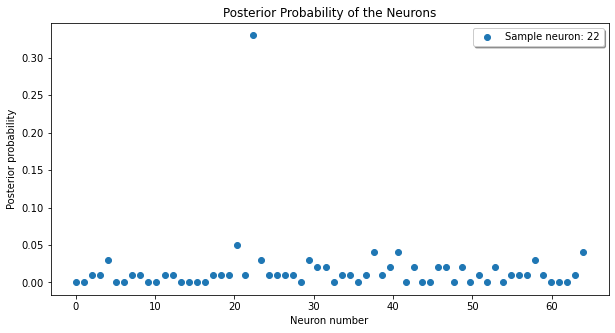

In [251]:
sample_neuron_number = 22
total_time = 1 #sec
sampling_rate = 1/5e-3
numberOFsampling = int(total_time*sampling_rate)
plt.figure(figsize = (10,5))
plt.scatter(np.linspace(0,64,64), posterior_prob_r(Pf[:,sample_neuron_number], N_sampling))
plt.title('Posterior Probability of the Neurons')
plt.xlabel('Neuron number')
plt.ylabel('Posterior probability')
plt.legend(["Sample neuron: %.0f" %sample_neuron_number], loc='upper right', fancybox=True, shadow=True)

Text(0, 0.5, 'Neuron number')

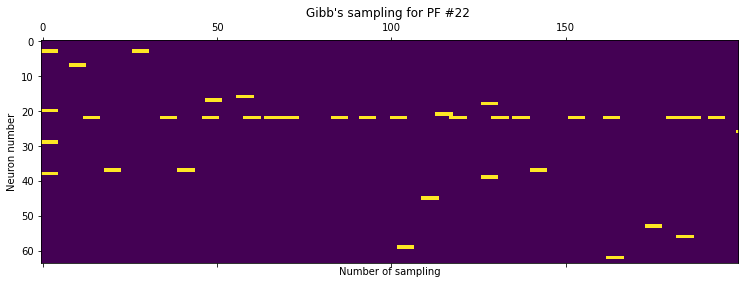

In [252]:
response = Gibbs_sampling(Pf[:,sample_neuron_number], N_sampling);

plt.matshow(response)
plt.title("Gibb's sampling for PF #%.f "%sample_neuron_number)
plt.xlabel("Number of sampling")
plt.ylabel('Neuron number')

## Trial with combination of projective fields

We choosed two different PF couples with low and high correlation. In this way we can see the performance of the PFs and observe the competation bw the PFs with high correlation.

In [253]:
def I_est(I, numberOFsampling):
    I_64 = I.reshape(64)
    posterior_array = posterior_prob_r(I_64, numberOFsampling)
    weighted_PFs = np.matmul(Pf,posterior_array)
    return weighted_PFs.reshape(8,8)

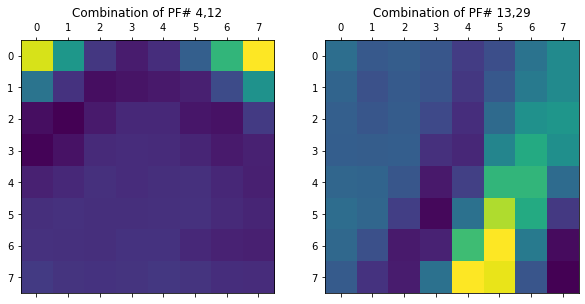

In [254]:
average_24_26 = (Pf[:,23].reshape(8,8)+Pf[:,25].reshape(8,8))/2
average_15_23 = (Pf[:,14].reshape(8,8)+Pf[:,22].reshape(8,8))/2

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax = axes[0].matshow(average_24_26)
ax = axes[1].matshow(average_15_23)

axes[0].set_title('Combination of PF# 4,12')
axes[1].set_title('Combination of PF# 13,29')

plt.show()

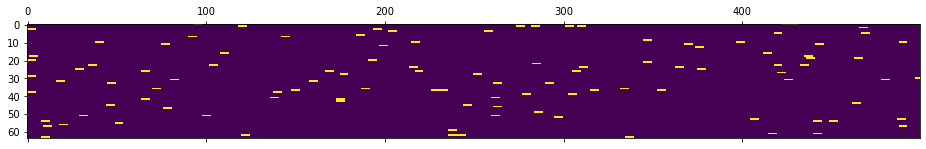

In [255]:
response_24_26 = Gibbs_sampling(average_24_26.reshape(64), N_sampling)
plt.matshow(response_24_26)

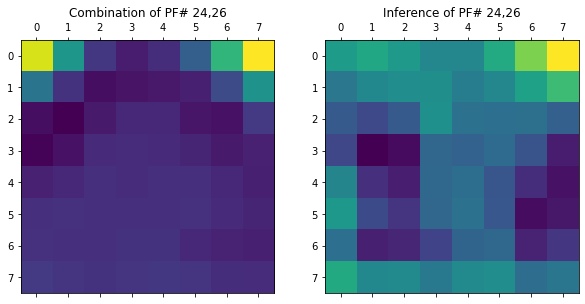

In [256]:
I_estimate_24_26 = I_est(average_24_26, numberOFsampling)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax = axes[0].matshow(average_24_26)
ax = axes[1].matshow(I_estimate_24_26)

axes[0].set_title('Combination of PF# 24,26')
axes[1].set_title('Inference of PF# 24,26')

plt.show()

In [257]:
corr_24_26 = pearsonr(I_estimate_24_26.reshape(64),average_24_26.reshape(64))
corr_24_26

(0.6104641802328079, 8.511592811159143e-08)

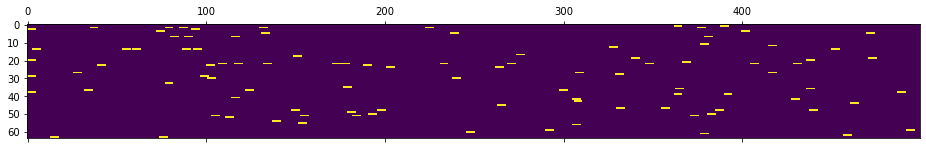

In [258]:
response_15_23 = Gibbs_sampling(average_15_23.reshape(64), N_sampling)
plt.matshow(response_15_23)

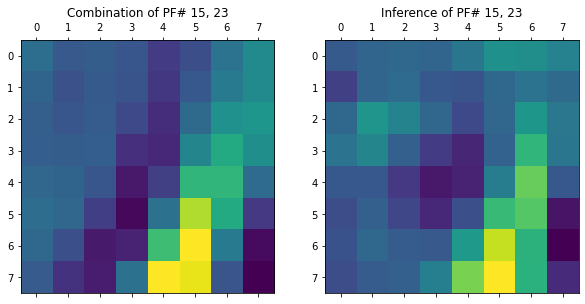

In [259]:
I_estimate_15_23 = I_est(average_15_23, numberOFsampling)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax = axes[0].matshow(average_15_23)
ax = axes[1].matshow(I_estimate_15_23)

axes[0].set_title('Combination of PF# 15, 23')
axes[1].set_title('Inference of PF# 15, 23')

plt.show()

In [260]:
corr_15_23 = pearsonr(I_estimate_15_23.reshape(64),average_15_23.reshape(64))
corr_15_23

(0.8255876466867135, 4.7477923677170415e-17)

Comparison of the correlation coefficient of the combined PFs is as follows

In [261]:
print("The correlation between the PF 4, and 12 is %.3f" %pearsonr(PFs[23].reshape(64),PFs[25].reshape(64))[0])
print("The correlation between the PF 15, and 23 is %.3f" %pearsonr(PFs[14].reshape(64),PFs[22].reshape(64))[0])  

The correlation between the PF 4, and 12 is -0.079
The correlation between the PF 15, and 23 is 0.131


## Mean correlation vs number of sampling

In [262]:
rand_order = np.random.choice(10000, 1000, replace=False)       # Draw order of the images randomly
rand_images = np.zeros([1000,8,8])                              # Create empty array
i = 0
while i < 1000:                                                 # Chose random images from the collection
    rand_images[i] = images[rand_order[i]]                      # with the order drawn above
    i += 1

In [265]:
def calc_correlation(images, n_sampling):
    
    collection_length = np.shape(images)[0]
    est_images = []                               # Initiate list for image estimates
    correlation = []                              # Initiate list for correlation coeff.s
    p_value = []                                  # Initiate list for p values for corr. coeff.s
    
    for i in range(collection_length):            # Find correlation. Iterate over all selected images
        estimate = I_est(images[i],n_sampling)
        c_coeff, p = pearsonr(images[i].reshape(64), estimate.reshape(64))
        est_images.append(estimate)
        correlation.append(c_coeff)
        p_value.append(p)
        
    return    est_images,   correlation,   p_value        

In [266]:
est, corr, p = calc_correlation(rand_images, numberOFsampling)

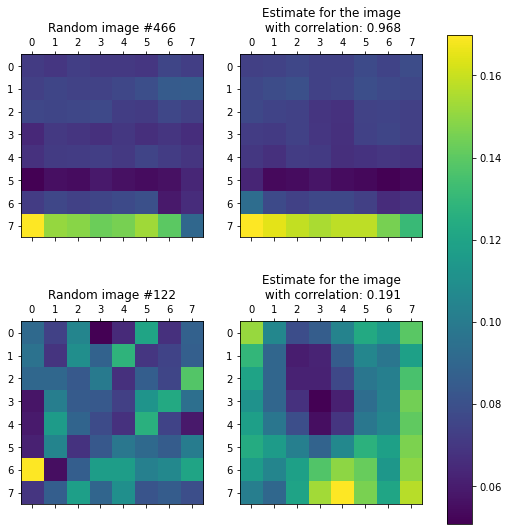

In [267]:
max_corr_order = corr.index(max(corr))
min_corr_order = corr.index(min(corr))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))

ax = axes[0][0].matshow(rand_images[max_corr_order])
ax = axes[0][1].matshow(est[max_corr_order])
ax = axes[1][0].matshow(rand_images[min_corr_order])
ax = axes[1][1].matshow(est[min_corr_order])

axes[0][0].set_title('Random image #%.f' %max_corr_order)
axes[0][1].set_title('Estimate for the image\n with correlation: %.3f' %corr[max_corr_order])
axes[1][0].set_title('Random image #%.f' %min_corr_order)
axes[1][1].set_title('Estimate for the image\n with correlation: %.3f' %corr[min_corr_order])

fig.colorbar(ax, ax=axes[:, :], location='right')

plt.show()

In [268]:
est_images = np.array([I_est(rand_images[i],numberOFsampling) for i in range(1000)])

In [269]:
n_sampling = np.linspace(10, 300, 10, dtype = int)
mean_correlation = []

for i in n_sampling:
    estI, corrI, pI = calc_correlation(rand_images, i)
    mean_correlation.append(np.mean(corrI))

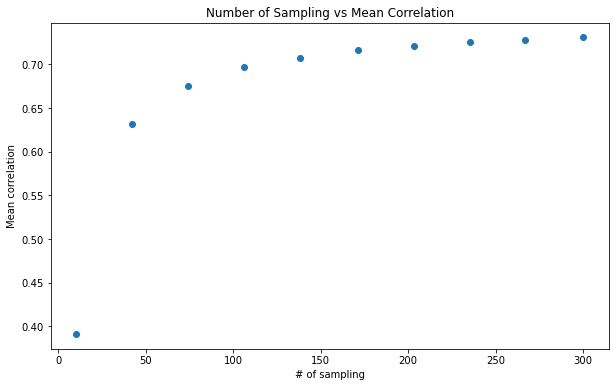

In [270]:
plt.figure(figsize=(10,6));
plt.scatter(n_sampling, mean_correlation);
plt.title("Number of Sampling vs Mean Correlation");
plt.xlabel("# of sampling");
plt.ylabel("Mean correlation");

## Rotating sin wave

Text(0.5, 1.0, 'Sin(x) wave with -pi/3 rotation')

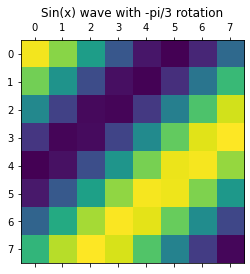

In [271]:
x = np.linspace(-np.pi, np.pi, 8)
y = np.linspace(-np.pi, np.pi, 8)

def sin_wave(x, y, rotation):
    xx, yy = np.meshgrid(x,y) 
    z = np.sin(xx*np.cos(rotation) - yy*np.sin(rotation))       
    return z

rot_angles = np.linspace(-np.pi, np.pi, 12)                                    # Define rotation angles
rotating_images = np.array([sin_wave(x, y, rot_angles[i]) for i in range(12)]) # One-liner for oriented image generation
plt.matshow(rotating_images[4])
plt.title("Sin(x) wave with -pi/3 rotation")

In [276]:
posterior_rotating_sine = np.array([posterior_prob_r(rotating_images[i].reshape(64), numberOFsampling)\
                                    for i in range(12)])

print(np.shape(posterior_rotating_sine))

(12, 64)


Text(0.5, 0, 'Orientation of the sin wave')

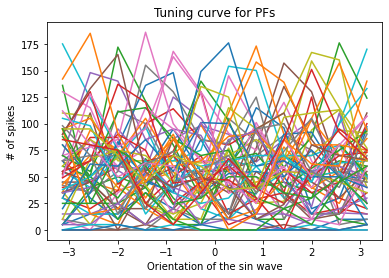

In [277]:
for i in range(64):
    plt.plot(rot_angles, posterior_rotating_sine[:,i]*numberOFsampling)
plt.title("Tuning curve for PFs")
plt.ylabel("# of spikes")
plt.xlabel("Orientation of the sin wave")

In [278]:
print("Mean firing rate for PFs are %.1f."%np.mean(posterior_rotating_sine*numberOFsampling))

Mean firing rate for PFs are 56.1.


## ISI distribution and CV of this ditribution

In [328]:
def Gibbs_sampling_timing(Image, n_sampling):
    response_matrix = np.zeros([64,n_sampling])  # Initiate sampling matrix
    response_matrix[:,0] = z_initial             # Set z_initial as the first column
    
    ζ = np.zeros([64,n_sampling])                # accompanying matrix showing the refractory period
    ζ[:,0] = z_initial*tau                       # firing neurons get into refractory period
    
    spike_timing = np.zeros([64,n_sampling])     # record spike times
    
    for i in range(1, n_sampling):               # Start from the second column, and iterate through time
        response_matrix[:,i] = response_matrix[:,i-1]
        
###### Discuss whether we should update it syncronously or (in-line)
# they will effect each other in the same sampling if we do it in-line

        for j in range(64):                       
            if ζ[j, i-1] <= 1:                   # Make a draw if refractory period is end
                
                response_matrix[j, i] = 0
                transfer_ij = expit(post_synaptic_potential(Image, j, response_matrix[:,i])\
                                    - np.log(tau)) # expit for sigmoid fct
                response_matrix[j,i] = np.random.binomial(1, transfer_ij)
                
                if response_matrix[j,i] == 1:   # update refractory period
                    ζ[j, i] = tau                
                    spike_timing[j, i] = i      # record spike time
                else:
                    ζ[j, i] = 0
                
            else:
                ζ[j, i] = ζ[j, i-1] - 1
   
    return spike_timing, response_matrix

In [329]:
def ISI_response(Image, n_sampling):
    spike_time_matrix, response = Gibbs_sampling_timing(Image, n_sampling)
    ISI = []
    for i in range(64):
        time = np.nonzero(spike_time_matrix[i])
        time = np.asarray(time[0])
        ISI.append([time[i+1]-time[i] for i in range(len(time)-1)])
    return ISI, response

In [343]:
ISI , response = ISI_response(average_24_26, N_sampling)
ISI = flat_list = [item for sublist in ISI for item in sublist]
std_ISI = np.std(ISI)
mean_ISI = np.mean(ISI)
cv_ISI = std_ISI/mean_ISI

In [ ]:
x * (x > 0)

Associated CV value for this ISI distribution is: 0.9


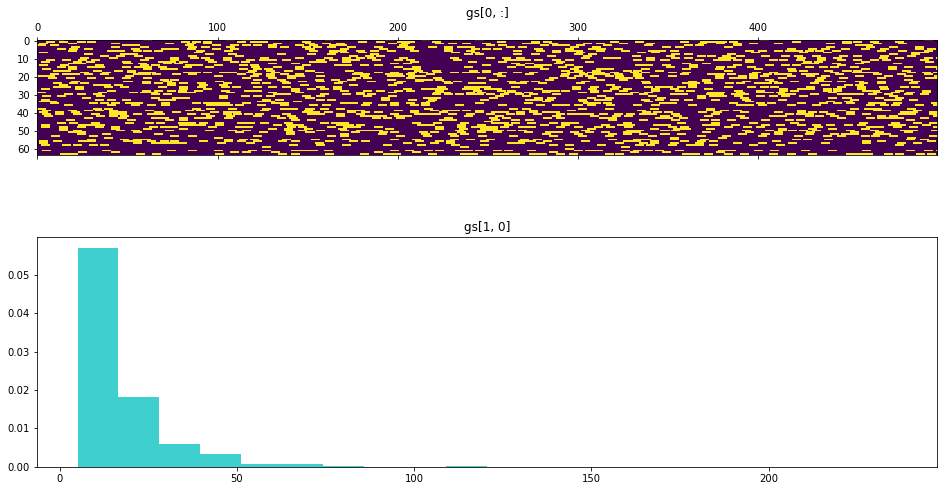

In [348]:
fig3 = plt.figure(constrained_layout=True, figsize = (13,7))
gs = fig3.add_gridspec(2, 2)
f3_ax1 = fig3.add_subplot(gs[0, :])
f3_ax1.set_title('gs[0, :]')
f3_ax1.matshow(aa)
f3_ax2 = fig3.add_subplot(gs[1, :])
f3_ax2.set_title('gs[1, 0]')
f3_ax2.hist(ISI, 20, density=True, facecolor='c', alpha=0.75);


In [349]:
print("Associated CV value for this ISI distribution is: %.1f" %cv_ISI)

Associated CV value for this ISI distribution is: 0.9


## Spike timing dependent plasticity 

As a way of learning, neurons weaken or strengthen the connection between them to facilitate a cognitive function. We know that neurons work as a network, and firing is wiring in that scheme. Than a contingent firing patter inside the network should be showing us a pathway. Then, the pathway facilitating a cognitive function can be understood as a flow of information, and the most efficient way would be the one with min redundancy. The previous studies showed that, neurons tend to reduce that redundancy by arranging their wiring strength according to the contingency of the relation between them.

According to the data (Zhang et al. 1998) and models (e.g, Song et al. 2000), Jesper Sjöström and Wulfram Gerstner report that this time constant tau should be on the order of 10 ms.

In [ ]:
weight_i = copy.copy(W[i])
tau_STDP = 10
def post_synaptic_potential_weight(Image, i, z):    
    weight_i[i] = 0                                                    # w_ii = 0
    time_course = np.matmul(np.transpose(weight_i),z)                  # how other neurons contribute PSP now
    bias = np.matmul(np.transpose(Pf[:,i]),Image.reshape(64,1))        # regulation of own excitability
    return bias - time_course

In [ ]:
def Gibbs_sampling_weight(Image, n_sampling):
    response_matrix = np.zeros([64,n_sampling])  # Initiate sampling matrix
    response_matrix[:,0] = z_initial             # Set z_initial as the first column
    
    ζ = np.zeros([64,n_sampling])                # accompanying matrix showing the refractory period
    ζ[:,0] = z_initial*tau                       # firing neurons get into refractory period
    
    spike_timing = np.zeros([64,n_sampling])     # record spike times
    
    for i in range(1, n_sampling):               # Start from the second column, and iterate through time
        response_matrix[:,i] = response_matrix[:,i-1]
        
###### Discuss whether we should update it syncronously or (in-line)
# they will effect each other in the same sampling if we do it in-line

        for j in range(64):                       
            if ζ[j, i-1] <= 1:                   # Make a draw if refractory period is end
                
                response_matrix[j, i] = 0
                transfer_ij = expit(post_synaptic_potential(Image, j, response_matrix[:,i])\
                                    - np.log(tau)) # expit for sigmoid fct
                response_matrix[j,i] = np.random.binomial(1, transfer_ij)
                
                if response_matrix[j,i] == 1:   # update refractory period
                    ζ[j, i] = tau                
                    spike_timing[j, i] = i      # record spike time
                    
                    #### Check and update the weight
                    #### update fct 
                    
                else:
                    ζ[j, i] = 0
                
            else:
                ζ[j, i] = ζ[j, i-1] - 1
   
    return spike_timing, response_matrix

show same image for a long time

show series of natural images for 10 ms each(that will be highly dependent on initial spiking pattern. better we should start by setting all neurons 0)